<h1>Notation</h1>
<ul>
    <li>F - State Transition Matrix</li>
    <li>G - Process Noise Transformation</li>
    <li>H - Observation Matrix(State Tracks more variables than what is measured)</li>
    <li>R - Measurement Noise Covariance</li>
    <li>Q - Process Noise Covariance</li>
    <li>x0,P - Initial state and state covariance</li>
    <li> C - Weighted Adjacencey Matrix</li>
</ul>

In [2]:
import numpy as np
import scipy as sp
class Node:
    def __init__(self,id,F,G,H,R,Q,x0,P):
        self.id = id
        self.F = F
        self.G = G
        self.H = H
        self.R = R
        self.Q = Q

        #Has an instance for each node
        self.x = x0
        self.n = len(x0)

        self.P = P

        self.nbhrs = []
        self.nbhr_weights = {}

        self.psi = np.zeros(x0.shape)
    
    def predict(self):
        self.x = self.F@(np.sum([self.nbhr_weights[node.id]*node.psi for node in self.nbhrs],0))
        self.P = (self.F@self.P@self.F.T) + (self.G@self.Q@self.G.T)

    def update(self, y):
        S = lambda node: (node.H @self.P @ node.H.T) + node.R
        #Original Code for K
        #K = {node.id: self.P@ node.H.T @ np.linalg.inv(S(node)) for node in self.nbhrs}
        #We use a solver to avoid inverses:
        #K[i]@S = P@H[i].T --> S.T@K[i].T = H[i]@P.T --> cholesky solve for K[i]
        K = {node.id:sp.linalg.cho_solve(sp.linalg.cho_factor(S(node).T),(node.H @ self.P.T)).T for node in self.nbhrs}
        
        I = lambda node: y[node.id] - (node.H @self.psi)
        self.psi = self.x

        for node in self.nbhrs:
            self.psi = self.psi+(K[node.id]@I(node))
        
        for node in self.nbhrs:
            self.P = (np.eye(self.n,self.n) - K[node.id]@node.H)@self.P


class DiffKF:
    def __init__(self,C,F,G,H,R,Q,x0,P):
        
        #Number of nodes
        self.n = len(x0)

        #weighted adjacencey matrix, nodes must be connected to themselves
        self.C = C

        self.nodes = []
        for i in range(self.n):
            self.nodes.append(Node(i,F[i],G[i],H[i],R[i],Q[i],x0[i],P[i]))
        
        for i in range(self.n):
            for j in range(self.n):
                if self.C[i][j] != 0:
                    self.nodes[i].nbhrs.append(self.nodes[j])
                    self.nodes[i].nbhr_weights[j] = C[i][j]
    
    def predict(self): #a.k.a diffusion update
        result = []
        for node in self.nodes:
            node.predict()
            result.append(node.x)
        
        return result
        
    
    def update(self, y): #a.k.a Incremental update
        for i,node in enumerate(self.nodes):
            node.update(y)

<h1>Example Description</h1>
<p>We have an object moving in the plane and our state(x) is it's position, velocity, and acceleration in the x and y directions. We have 4 nodes in a square/loop which each get measurements of the location every second with different noise. They communicate with their neighbors and weigh estimates equally*(33/100 from two neighbor estimates and 34/100 for personal estimate)</p>
<p>The plots show the Estimates vs Measurements of each of the four nodes and then a convergence plot that averages the error from each of the four nodes.</p>

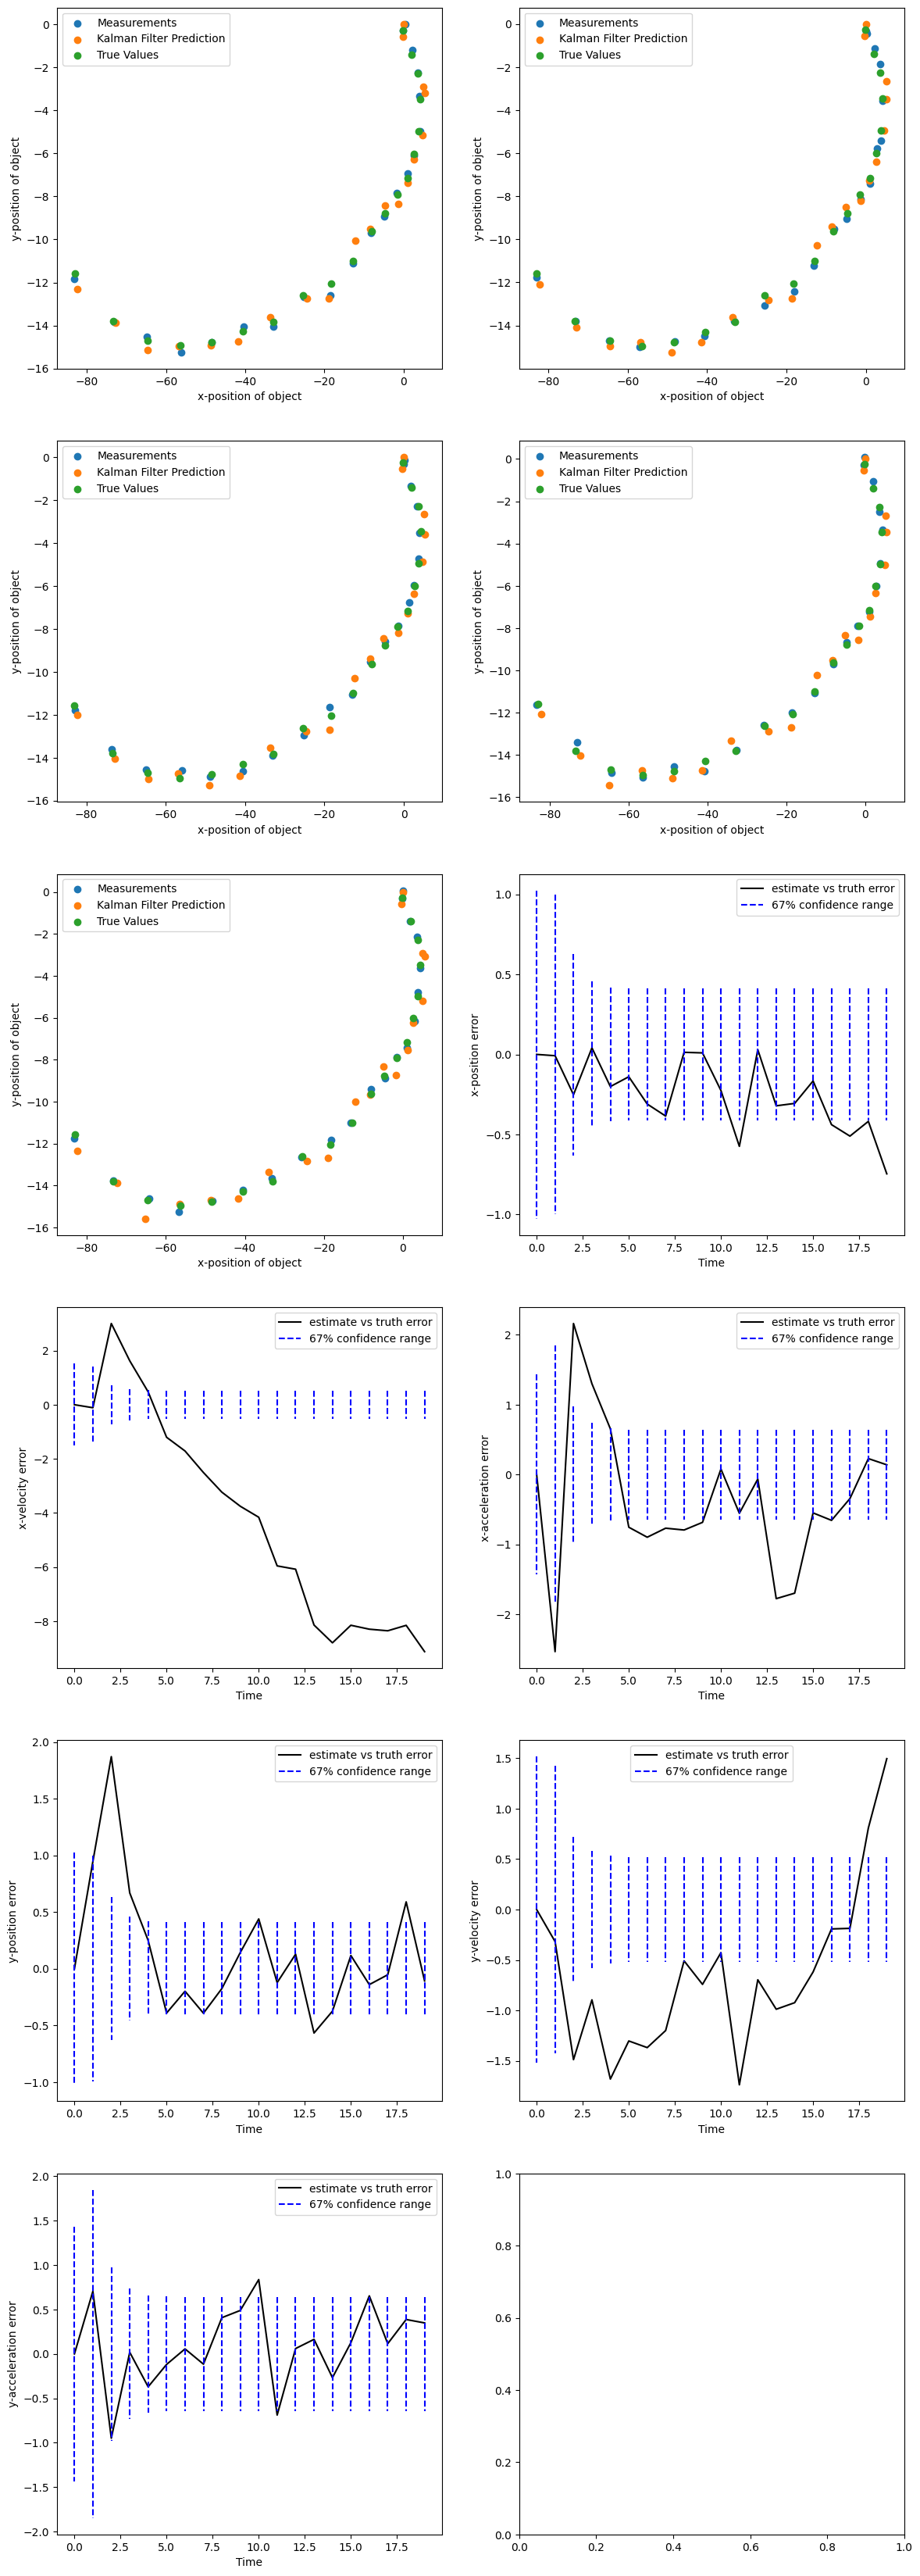

In [5]:
import matplotlib.pyplot as plt
np.random.seed(163)
def example(iters):
    C = np.array([[0.34,0.33, 0, 0, 0.33],[0.33,0.34,0.33,0,0],[0,0.33,0.34,0.33,0],[0,0,0.33,0.34,0.33],[0.33,0,0,0.33,0.34]])
    n = len(C[0])

    F = [np.array([[1, 1, 0.5, 0, 0, 0], [0, 1, 1, 0, 0, 0],[0,0,1,0,0,0], [0, 0, 0, 1, 1, 0.5], [0,0,0,0,1,1],[0,0,0,0,0,1]]) for _ in range(n)]
    G = [np.eye(6) for _ in range(n)]
    H = [np.array([[1, 0, 0, 0, 0, 0],[0,0,0,1,0,0]]) for _ in range(n)]

    Q = [np.array([[0.05, 0, 0, 0, 0, 0], [0, 0.05, 0, 0, 0, 0],[0,0,0.05,0,0,0], [0, 0, 0, 0.05, 0, 0], [0,0,0,0,0.05,0],[0,0,0,0,0,0.05]]) for _ in range(n)]
    R = [np.array([[0.04,0],[0,0.04]]) for _ in range(n)]

    #This is the true starting value that we update to get true values
    xp = np.array([[0,2,-1,0,-1,0.1]]).T

    m = len(xp)

    #These are random first estimates for each of the nodes
    x0 = [np.array([[np.random.normal(0,2) for _ in range(6)]]).T for k in range(n)]

    P = [np.eye(6) for _ in range(n)]


    DKF = DiffKF(C,F,G,H,R,Q,x0,P)

    procc_noise = lambda i : np.linalg.cholesky(Q[i]) @ np.random.normal(np.array([[0,0,0,0,0,0]]).T)
    measure_noise = lambda i : np.linalg.cholesky(R[i]) @ np.random.normal(np.array([[0,0]]).T)

    z = [(H[0] @ xp)+measure_noise(i) for i in range(n)]

    truth = np.zeros((iters+1,m,1))
    truth[0] = xp+procc_noise(0)
    predictions = {i:[] for i in range(n)}
    measurements = [z]
    errors = np.zeros((iters,n,m,1))
    P_hist = np.zeros((iters,n,m,m))
    for i in range(iters):
        x = DKF.predict()
        for j in range(n):
            predictions[j].append(H[j]@x[j])
        z = [(H[0] @ truth[i])+measure_noise(j) for j in range(n)]
        truth[i+1] = F[0]@truth[i]+procc_noise(0)
        measurements.append(z)
        errors[i] = np.array([node.x-truth[i-1] for node in DKF.nodes])
        P_hist[i] = np.array([node.P for node in DKF.nodes])
        DKF.update(z)

    
    fig,axs = plt.subplots((n+m)//2 +1,2, figsize=(14, 7*((n+m)//2+1)))
    for i in range(n):
        axs[i//2][i%2].scatter([x[i][0][0] for x in measurements],[x[i][1][0] for x in measurements], label = 'Measurements')
        axs[i//2][i%2].scatter([x[0][0] for x in predictions[i]],[x[1][0] for x in predictions[i]], label = 'Kalman Filter Prediction')
        axs[i//2][i%2].scatter([(H[i]@x)[0][0] for x in truth[:-1]],[(H[i]@x)[1][0] for x in truth[:-1]], label = 'True Values')
        axs[i//2][i%2].set_xlabel("x-position of object")
        axs[i//2][i%2].set_ylabel("y-position of object")
        axs[i//2][i%2].legend()
    
    t_hist = np.arange(0, iters, 1)
    labels = ["x-position", "x-velocity","x-acceleration","y-position","y-velocity","y-acceleration"]
    for k in range(n,n+m):
        axs[k//2][k%2].plot(t_hist, errors[:, 0, k%m], 'k',label = "estimate vs truth error")
        axs[k//2][k%2].plot(np.vstack([t_hist[0], t_hist[0]]), np.vstack([np.sqrt(P_hist[0, 0,k%m, k%m]), -np.sqrt(P_hist[0, 0,k%m, k%m])]), 'b--',label = "67% confidence range")
        axs[k//2][k%2].plot(np.vstack([t_hist[1:], t_hist[1:]]), np.vstack([np.sqrt(P_hist[1:, 0,k%m, k%m]), -np.sqrt(P_hist[1:, 0,k%m, k%m])]), 'b--')
        axs[k//2][k%2].set_xlabel("Time")
        axs[k//2][k%2].set_ylabel(labels[(k-n)%m]+" error")
        axs[k//2][k%2].legend()

    plt.show()

example(20)

    